## 📌 Análise Preditiva para Aprovação de Empréstimos
Sobre o dataset: O conjunto de dados de aprovação de empréstimo é uma coleção de registros financeiros e informações associadas usadas para determinar a elegibilidade de indivíduos ou organizações para obter empréstimos de uma instituição de empréstimo. Inclui vários fatores, como pontuação cibil, renda, status de emprego, prazo do empréstimo, valor do empréstimo, valor dos ativos e status do empréstimo.


### **1️⃣ Objetivo**
Construir um modelo de **classificação** utilizando **Árvore de Decisão** para prever se um empréstimo será **aprovado ou rejeitado**, com base em diversas variáveis financeiras e pessoais.

### **2️⃣ Preparação dos Dados**
- **Variável Alvo:** `loan_status` (Aprovado ou Rejeitado)
- **Variáveis Explicativas:**
  - `cibil_score` (pontuação de crédito)
  - `loan_amount` (valor do empréstimo)
  - `loan_term` (prazo do empréstimo)
  - `residential_assets_value` (ativos residenciais)
  - `income_annum` (renda anual)
  - Outras características como número de dependentes e nível educacional.


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
import pickle
import warnings
warnings.filterwarnings('ignore')

In [8]:
# Carrega o dataset
df = pd.read_csv("loan_approval_dataset.csv")

In [9]:
# Faz uma limpeza nas colunas
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')


In [10]:
# Aqui ele exclui o loan_id
df.drop(columns=['loan_id'], inplace=True)


In [11]:
# Lida com valores ausentes
imputer = SimpleImputer(strategy='most_frequent')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)


In [12]:
# Codifica as colunas categoricas
cat_cols = df_imputed.select_dtypes(include=['object']).columns
encoder = LabelEncoder()
for col in cat_cols:
    df_imputed[col] = encoder.fit_transform(df_imputed[col])

In [13]:
# Separa as funcionalidades do alvo
X = df_imputed.drop('loan_status', axis=1)
y = df_imputed['loan_status']

In [14]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
# Definição de quais modelos serao usados
models = {
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}


In [16]:
# Treina o modelo 30x
results = {}
for name, model in models.items():
    accuracies = []
    for i in range(30):
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=i)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)
    results[name] = np.mean(accuracies)

In [21]:
# Mostra um print do valor de todos os modelos
print("Acurácia média após 30 execuções:")
for model_name, avg_acc in results.items():
    print(f"{model_name}: {avg_acc:.4f}")

Acurácia média após 30 execuções:
Random Forest: 0.9824
Logistic Regression: 0.9179
KNN: 0.8972
Decision Tree: 0.9785


In [17]:
# Seleção do melhor modelo
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
print(f"Melhor modelo: {best_model_name} com acurácia média de {results[best_model_name]:.4f}")


Melhor modelo: Random Forest com acurácia média de 0.9824


In [22]:
# Treinamento final com todo o dataset
best_model.fit(X_scaled, y)

RandomForestClassifier()

In [24]:
# Extração das regras de decisão (se o modelo for uma árvore de decisão ou Random Forest)
from sklearn.tree import export_text

if best_model_name in ['Decision Tree', 'Random Forest']:
    print("\n# 📜 Regras de decisão extraídas do modelo")
    regras = export_text(best_model.estimators_[0] if best_model_name == 'Random Forest' else best_model,
                         feature_names=list(X.columns),
                         show_weights=True)
    print(regras)
else:
    print("\n# ℹ️ O modelo escolhido não é baseado em árvore, portanto a extração de regras não é aplicável.")



# 📜 Regras de decisão extraídas do modelo
|--- bank_asset_value <= 2.33
|   |--- bank_asset_value <= 1.90
|   |   |--- commercial_assets_value <= 2.41
|   |   |   |--- cibil_score <= -0.29
|   |   |   |   |--- loan_term <= -1.03
|   |   |   |   |   |--- loan_amount <= 0.89
|   |   |   |   |   |   |--- income_annum <= 0.21
|   |   |   |   |   |   |   |--- commercial_assets_value <= -0.53
|   |   |   |   |   |   |   |   |--- commercial_assets_value <= -0.60
|   |   |   |   |   |   |   |   |   |--- no_of_dependents <= -1.18
|   |   |   |   |   |   |   |   |   |   |--- weights: [9.00, 0.00] class: 0.0
|   |   |   |   |   |   |   |   |   |--- no_of_dependents >  -1.18
|   |   |   |   |   |   |   |   |   |   |--- loan_amount <= -0.01
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 11
|   |   |   |   |   |   |   |   |   |   |--- loan_amount >  -0.01
|   |   |   |   |   |   |   |   |   |   |   |--- weights: [5.00, 0.00] class: 0.0
|   |   |   |   |   |   |   |   |--

## 🧠 O que são as Regras de Decisão?

Essas regras são caminhos lógicos que vão da **raiz até as folhas** de uma **árvore de decisão** treinada com os dados de empréstimos. Cada linha representa uma condição que precisa ser satisfeita para continuar no caminho até a decisão final, que pode ser:

- **class: 0.0** → Empréstimo **Negado**
- **class: 1.0** → Empréstimo **Aprovado**

A notação `weights: [x, y]` indica **quantos exemplos de cada classe** chegaram naquele nó durante o treinamento, o que ajuda a avaliar a **confiabilidade da decisão**.

---

## 📊 Como interpretar as regras

Suponha esta sequência:



|--- cibil_score <= -0.29 | |--- loan_term <= -1.03 | | |--- income_annum <= 0.21 | | | |--- weights: [9.00, 0.00] class: 0.0


### 🧩 Interpretação:

- Se o **score de crédito (cibil_score)** for **baixo** (≤ -0.29),
- E o **prazo do empréstimo (loan_term)** for **curto** (≤ -1.03),
- E a **renda anual (income_annum)** for **baixa** (≤ 0.21),
→ Então o **modelo nega o empréstimo**, com base em **9 exemplos anteriores** que também foram negados.

---

## 🔍 Exemplo de regra mais complexa

|--- income_annum > 0.21 | |--- no_of_dependents <= 0.59 | | |--- income_annum <= 0.78 | | | |--- loan_amount <= 0.38 | | | | |--- weights: [0.00, 20.00] class: 1.0


### 🧩 Interpretação:

- Se a **renda anual (income_annum)** for **acima de 0.21 e até 0.78**,
- E o número de **dependentes** for **baixo** (≤ 0.59),
- E o **valor do empréstimo (loan_amount)** solicitado for **baixo** (≤ 0.38),
→ Então o **empréstimo será aprovado**, com base em **20 exemplos anteriores de sucesso**.

---

Essas regras ajudam a tornar o modelo **mais transparente** e explicável para o usuário final, além de facilitar auditorias e tomadas de decisão.


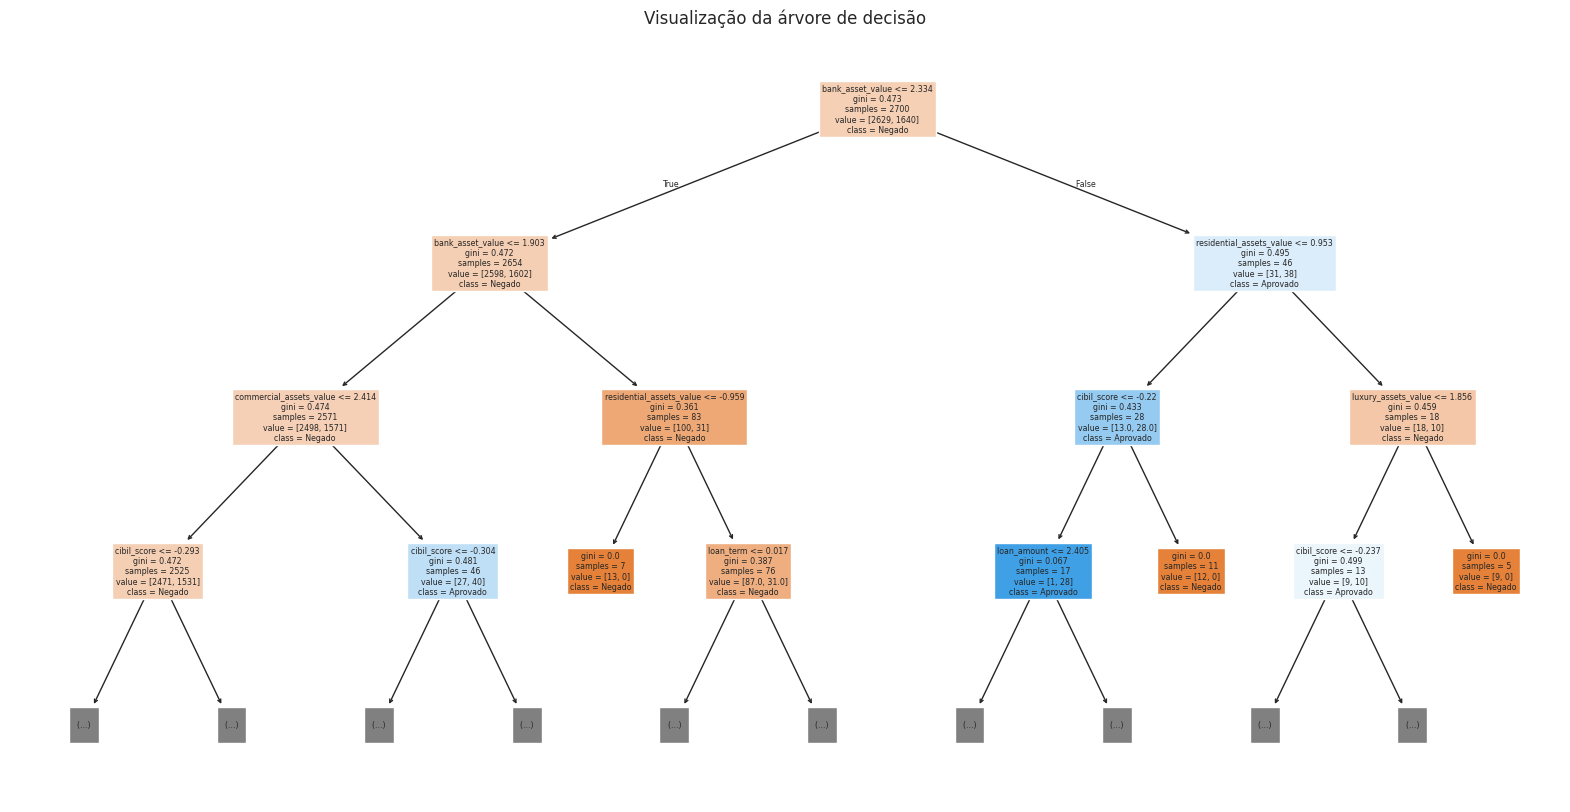

In [27]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(
    best_model.estimators_[0] if best_model_name == 'Random Forest' else best_model,
    feature_names=X.columns,
    class_names=["Negado", "Aprovado"],
    filled=True,
    max_depth=3
)
plt.title("Visualização da árvore de decisão")
plt.show()


In [26]:
regras = export_text(
    best_model.estimators_[0] if best_model_name == 'Random Forest' else best_model,
    feature_names=list(X.columns),
    max_depth=3,  # Limita a profundidade da árvore a 3 níveis
    show_weights=True
)
print(regras)


|--- bank_asset_value <= 2.33
|   |--- bank_asset_value <= 1.90
|   |   |--- commercial_assets_value <= 2.41
|   |   |   |--- cibil_score <= -0.29
|   |   |   |   |--- truncated branch of depth 18
|   |   |   |--- cibil_score >  -0.29
|   |   |   |   |--- truncated branch of depth 7
|   |   |--- commercial_assets_value >  2.41
|   |   |   |--- cibil_score <= -0.30
|   |   |   |   |--- truncated branch of depth 5
|   |   |   |--- cibil_score >  -0.30
|   |   |   |   |--- weights: [19.00, 0.00] class: 0.0
|   |--- bank_asset_value >  1.90
|   |   |--- residential_assets_value <= -0.96
|   |   |   |--- weights: [13.00, 0.00] class: 0.0
|   |   |--- residential_assets_value >  -0.96
|   |   |   |--- loan_term <= 0.02
|   |   |   |   |--- truncated branch of depth 5
|   |   |   |--- loan_term >  0.02
|   |   |   |   |--- truncated branch of depth 4
|--- bank_asset_value >  2.33
|   |--- residential_assets_value <= 0.95
|   |   |--- cibil_score <= -0.22
|   |   |   |--- loan_amount <= 2.41
|

In [23]:
# Save the trained model
with open(f"best_loan_model2.pkl", "wb") as f:
    pickle.dump(best_model, f)



In [20]:
# Save the scaler as well (useful for future predictions)
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

#### Relatório dos Experimentos e Justificativa do Modelo Escolhido

#### Resumo dos Modelos Testados

Foram avaliados quatro algoritmos de classificação para o problema de predição de aprovação de empréstimos. Cada modelo foi executado **30 vezes** com diferentes seeds de aleatoriedade, utilizando uma divisão de 80% para treino e 20% para teste. As acurácias médias foram:

- **Random Forest**: 0.9824
- **Logistic Regression**: 0.9179
- **KNN (K-Nearest Neighbors)**: 0.8972
- **Decision Tree**: 0.9785

#### Melhor Modelo Escolhido

O modelo com a melhor performance foi o **Random Forest**, com uma acurácia média de **0.9824**.

#### Justificativa

O Random Forest foi escolhido como modelo final devido à sua robustez, alta capacidade de generalização e desempenho superior em comparação aos demais modelos testados. Ele combina múltiplas árvores de decisão e realiza votação entre elas, reduzindo significativamente o risco de overfitting.

Além disso, o Random Forest lida bem com dados categóricos e contínuos, exige menos pré-processamento dos dados e tem boa performance mesmo com variáveis correlacionadas, características presentes no dataset utilizado.

Esse modelo será utilizado para realizar predições futuras e foi salvo como `best_loan_model.pkl`, acompanhado do scaler `scaler.pkl` para garantir compatibilidade nas entradas padronizadas.

